In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
%cd drive
%cd MyDrive
%cd ECE\ 232E/
%cd Project4/

[Errno 2] No such file or directory: 'drive'
/content/drive/MyDrive/ECE 232E/Project4
[Errno 2] No such file or directory: 'MyDrive'
/content/drive/MyDrive/ECE 232E/Project4
[Errno 2] No such file or directory: 'ECE 232E/'
/content/drive/MyDrive/ECE 232E/Project4
[Errno 2] No such file or directory: 'Project4/'
/content/drive/MyDrive/ECE 232E/Project4


In [60]:
!pip install igraph
import pandas
import numpy as np
import igraph
import json
%ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
igraph_data
los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv
los_angeles_censustracts.json
q9_16.ipynb


In [61]:
# test
with open('los_angeles_censustracts.json') as f:
    census_tracts = json.loads(f.readline())
display_names = dict()
coordinates = dict()

for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

g = igraph.Graph(directed=False)
g.add_vertices(len(display_names))
g.vs['name'] = list(display_names.values())  # index = id - 1
g.vs['coordinate'] = list(coordinates.values())

month_filter = {12}  # for monthly aggregate data of 4th quarter, we can filter data based off of only December

edges = []
weights = []

with open('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv') as f:
    f.readline()  # skip the first line
    
    while True:
        line = f.readline()
        if line == '':
            break  # end of file
        
        vals = line.strip().split(',')
        
        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

        # if data is not relevant, skip it
        if month not in month_filter:
            continue
            
        edges.append((src - 1, dest - 1))
        weights.append(dist)

g.add_edges(edges)
g.es['weight'] = weights
print(f'# of nodes: {len(g.vs)}')
print(f'# of edges: {len(g.es)}')

# of nodes: 2716
# of edges: 1692450


In [62]:
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges
cleanGraph = g.components().giant()
print(f'# of nodes: {len(cleanGraph.vs)}')
print(f'# of edges: {len(cleanGraph.es)}')

# of nodes: 2649
# of edges: 1003858


# of nodes: 2649
# of edges: 1004955


In [63]:
mst = cleanGraph.spanning_tree(weights=cleanGraph.es['weight'])
for e in mst.es[10:19]:
  e0, e1 = e.tuple
  #v0 = vertexAttributes[int(float(mst.vs(e0).get_attribute_values('name')[0]))]
  #v1 = vertexAttributes[int(float(mst.vs(e1).get_attribute_values('name')[0]))]
  print('src centriod: {}, dst centriod: {}'.format(mst.vs(e0).get_attribute_values('coordinate')[0], mst.vs(e1).get_attribute_values('coordinate')[0]))

src centriod: [-118.1528085   34.098628 ], dst centriod: [-118.15508201   34.10732695]
src centriod: [-118.15075124   34.08341963], dst centriod: [-118.15266639   34.09029573]
src centriod: [-118.15266639   34.09029573], dst centriod: [-118.15023891   34.09595766]
src centriod: [-118.14184446   34.08538654], dst centriod: [-118.14162277   34.08013327]
src centriod: [-118.13948648   34.07262509], dst centriod: [-118.12195981   34.07206641]
src centriod: [-118.13948648   34.07262509], dst centriod: [-118.14907131   34.06458611]
src centriod: [-118.11315003   34.08121859], dst centriod: [-118.12195981   34.07206641]
src centriod: [-118.11315003   34.08121859], dst centriod: [-118.10959973   34.06754916]
src centriod: [-118.11315003   34.08121859], dst centriod: [-118.0975576    34.07361118]


In [64]:
# Q11
samples = list()
while len(samples) < 1000:
  try:
    v1, v2, v3 = np.random.randint(1, len(cleanGraph.vs), 3)
    e1, e2, e3 = cleanGraph.get_eid(v1, v2), cleanGraph.get_eid(v2, v3), cleanGraph.get_eid(v1, v3)
    weights = [cleanGraph.es['weight'][id] for id in [e1, e2, e3]]
    samples.append(weights)
  except: pass
count = 0
for w1, w2, w3 in samples:
  if w1+w2 > w3 and w2+w3 > w1 and w1+w3 > w2:
    count += 1
print(f'The percentage of points satisfying triangle inequality: {count/1000*100:.2f}')

The percentage of points satisfying triangle inequality: 91.00


In [65]:
# Q12
# distance matrix for the clean graph
distance = cleanGraph.shortest_paths_dijkstra(source=cleanGraph.vs, target=cleanGraph.vs, weights='weight')

In [66]:
import networkx as nx
import random

mg = nx.MultiGraph()
for e in mst.es:
  v0, v1 = e.tuple
  mg.add_edge(v0, v1, weight=e['weight'])
  mg.add_edge(v0, v1, weight=e['weight'])

startPoints = [v for v in mg.nodes]
startPoints = random.choices(startPoints, k=50)

trajectory = list()
cost = list()
for start in startPoints:
  walk = [u for u,v in nx.eulerian_circuit(mg, source=start)]
  path = list()
  visited = set()
  for node in walk:
    if node not in visited:
      visited.add(node)
      path.append(node)
  path.append(path[0])
  trajectory.append(path)

  dist = 0
  for i in range(len(path)-1):
    n1, n2 = path[i], path[i+1]
    dist += distance[n1][n2]
  cost.append(dist)

mst_cost = sum(mst.es.get_attribute_values('weight'))
tsp_cost = min(cost)
tsp = trajectory[np.argmin(tsp_cost)]
print(f'mst_cost={mst_cost}')
print(f'tsp_cost={tsp_cost}')
print(f'upperbound={tsp_cost/mst_cost:.2f}')

mst_cost=269084.5449999994
tsp_cost=425823.9249999999
upperbound=1.58


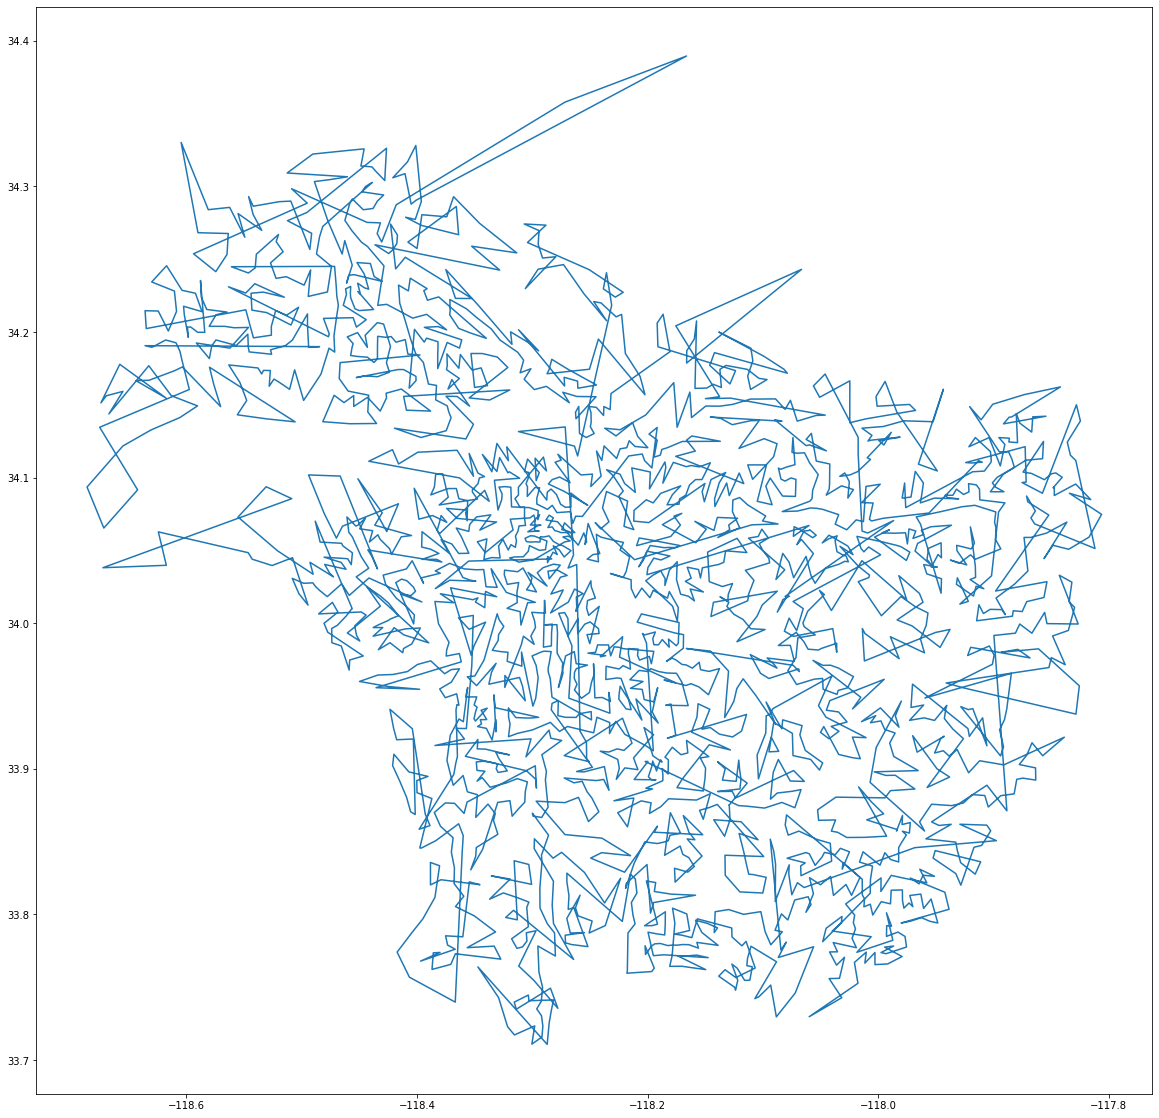

In [69]:
# Q13
import matplotlib.pyplot as plt

tsp_coordinates = np.array(cleanGraph.vs['coordinate'])[tsp, :]
plt.figure(figsize=(20,20))
plt.plot(tsp_coordinates[:, 0], tsp_coordinates[:, 1],'-')
plt.show()

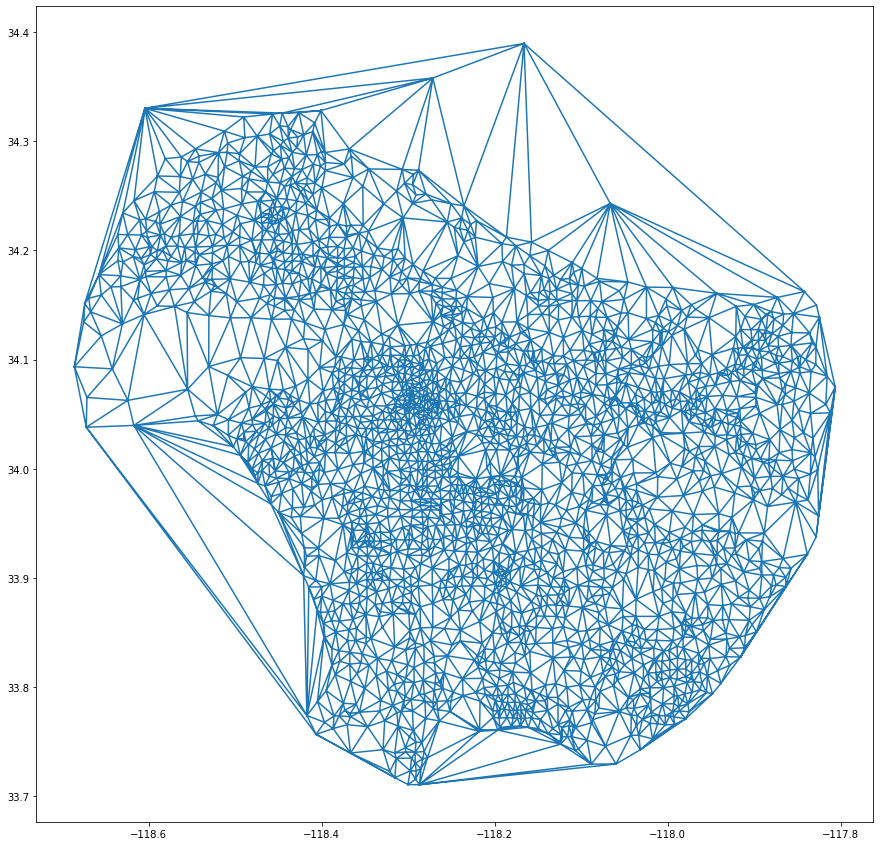

In [70]:
# Q14
from scipy.spatial import Delaunay

coordinates = np.array(cleanGraph.vs['coordinate'])
tri = Delaunay(coordinates)
plt.figure(figsize=(15,15))
plt.triplot(coordinates[:, 0], coordinates[:, 1], tri.simplices.copy())
plt.show()

In [78]:
# G_delta
edges = list()
added = set()
triGraph = igraph.Graph(directed=False)
triGraph.add_vertices(len(tri.points))
triGraph.vs['coordinate'] = cleanGraph.vs['coordinate']
for i in range(tri.simplices.shape[0]):
    for col1, col2 in ((0, 1), (1, 2), (0, 2)):
      e = [tri.simplices[i, col1], tri.simplices[i, col2]]
      e.sort()
      e = tuple(e)
      if e not in added:
        edges.append(e)
        added.add(e)
triGraph.add_edges(edges)

In [ ]:
# Q15 idk what this is doing
edge_ends = #write here 
sources, targets = #write here 
distances = #write here 
speeds =  # write here   # mph
car_length = 0.003  # (miles)
safety_distances = speeds * (2/3600)  # in miles, derived from 2 sec distance
cars_per_mile = 1 / (car_length + safety_distances)
n_lanes = 2
cars_per_hour = #write here 

SyntaxError: ignored

In [85]:
# Q16
malibu = [-118.5670548, 34.0458901]
longBeach = [-118.1819374, 33.759958]
longBeachNode = 0
longBeachDist = np.inf
malibuNode = 0
malibuDist = np.inf
for i, (lat, lon) in enumerate(triGraph.vs['coordinate']):
  ldist = np.sqrt((lat-longBeach[0])**2 + (lon-longBeach[1])**2)
  if ldist < longBeachDist:
    longBeachDist = ldist
    longBeachNode = int(i)
  mdist = np.sqrt((lat-malibu[0])**2 + (lon-malibu[1])**2)
  if mdist < malibuDist:
    malibuDist = mdist
    malibuNode = int(i)

print(f'# of edge-disjoint paths: {triGraph.adhesion(longBeachNode, malibuNode)-1}')
print(f'Degree Distribution of nodes (Malibu, Long Beach): ', triGraph.degree(malibuNode)-1,triGraph.degree(longBeachNode)-1)

# of edge-disjoint paths: 3
Degree Distribution of nodes (Malibu, Long Beach):  3 5


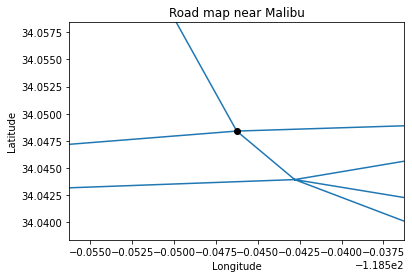

In [93]:
lon, lat = triGraph.vs(malibuNode).get_attribute_values('coordinate')[0]
plt.triplot(coordinates[:, 0], coordinates[:, 1], tri.simplices.copy())
plt.ylim(lat-0.01, lat+0.01)
plt.xlim(lon-0.01, lon+0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(lon, lat, 'o',color='black')
plt.show()

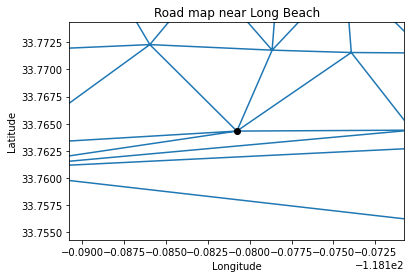

In [94]:
lon, lat = triGraph.vs(longBeachNode).get_attribute_values('coordinate')[0]
plt.triplot(coordinates[:, 0], coordinates[:, 1], tri.simplices.copy())
plt.ylim(lat-0.01, lat+0.01)
plt.xlim(lon-0.01, lon+0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(lon, lat, 'o',color='black')
plt.show()